In [1]:
import os, importlib, sys, time, h5py

In [2]:
import numpy as np
from scipy import io, linalg, stats, ndimage
from scipy.sparse import diags

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':15})
## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [4]:
import ladyns as ldn
import ladyns.inference as inf
import ladyns.optimize.core as core

In [5]:
importlib.reload(ldn)
importlib.reload(inf)
importlib.reload(core)

<module 'ladyns.optimize.core' from '/home/hbong/miniconda3/lib/python3.7/site-packages/ladyns/optimize/core.cpython-37m-x86_64-linux-gnu.so'>

# 0. load data

In [ ]:
save_dir = "../temp"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [6]:
data_dir = "../data"
file_name = ['lfp_bred_1.mat', 'lfp_bred_2.mat', 'lfp_bred_3.mat']
rec_time = [0, 0.5]

In [7]:
data = [
    np.concatenate([io.loadmat('%s/%s'%(data_dir, fname))['v4_bred']
                    for fname in file_name], 0).T,
    np.concatenate([io.loadmat('%s/%s'%(data_dir, fname))['pfc_bred']
                    for fname in file_name], 0).T]

In [8]:
data[0].shape, data[1].shape

((101, 25, 3000), (101, 25, 3000))

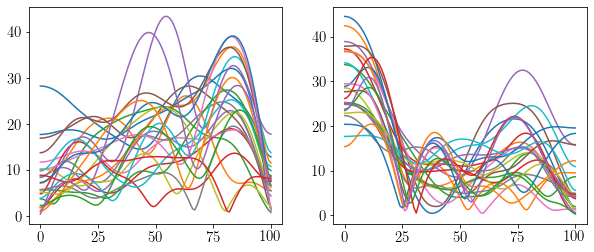

In [9]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1); plt.plot(data[0][:,:,0])
plt.subplot(1,2,2); plt.plot(data[1][:,:,0])
plt.show()

In [10]:
dims = [data[0].shape[1], data[1].shape[1]]
num_time = data[0].shape[0]
num_trial = data[0].shape[2]

# 1. parameter calibration

In [11]:
offset_cross=20
offset_auto=20
lambdas= np.vstack([
    np.exp(np.linspace(np.log(0.1), np.log(0.001), 11)), #np.full((11,), 0.06), ## lambdas_cross
    np.zeros(11), ## lambdas_auto
    np.full((11,), 0.5), ## lambdas_diag
    np.zeros(11)]) ## lambdas_ridge

In [12]:
time_graph_cross = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_cross)
time_graph_auto = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_auto)

In [13]:
b_time = np.linspace(rec_time[0], rec_time[1], num_time)
l_time = np.linspace(rec_time[0], rec_time[1], 2*num_time-1)

## calibration by permutation

In [14]:
num_cv = 10

In [15]:
Omegas_cv = np.zeros([num_cv, lambdas.shape[-1], 2*num_time, 2*num_time])
weights_cv = []

for iter_cv in np.arange(num_cv):
    start_cv = time.time()
    
    # random sample
    trial_sample = np.random.choice(num_trial, num_trial, False)
    data_bst = [data[0], data[1][:,:,trial_sample]]

    for iter_est, (lambda_cross, lambda_auto, lambda_diag, lambda_ridge) \
    in enumerate(zip(*lambdas)): 
        if iter_cv > 0:
            init_arg = {'Omega_init': Omegas_cv[0,iter_est],
                        'weight_init': weights_cv[iter_est]}
        elif iter_est > 0:
            init_arg = {'Omega_init': Omegas_cv[0,iter_est-1],
                        'weight_init': weights_cv[iter_est-1]}
        else:
            init_arg = dict()

        Omega_est, Sigma_est, latent_est, weight_est \
        = ldn.fit(data_bst, lambda_diag, lambda_cross, offset_cross,
                  lambda_auto, offset_auto, 
                  ths_glasso=1e-6, ths_lasso=1e-6, verbose=True,
                  **init_arg)
        
        # save result
        Omegas_cv[iter_cv, iter_est] = Omega_est
        if iter_cv == 0:
            weights_cv.append(weight_est)

    sys.__stdout__.write("%d-th cv finished, lapse: %.3fsec.\n"
                         %(iter_cv+1, time.time()-start_cv))
    sys.__stdout__.flush()

1-th iter, nll: 110.260128, change: 0.128547, lapse: 9.014047
2-th iter, nll: 110.186400, change: 0.006303, lapse: 6.750726
3-th iter, nll: 110.125247, change: 0.004513, lapse: 7.026724
4-th iter, nll: 110.072422, change: 0.003487, lapse: 6.887276
5-th iter, nll: 110.025816, change: 0.003205, lapse: 6.515354
6-th iter, nll: 109.984160, change: 0.003003, lapse: 6.252025
7-th iter, nll: 109.946584, change: 0.002861, lapse: 6.336645
8-th iter, nll: 109.912448, change: 0.002744, lapse: 6.172240
9-th iter, nll: 109.881265, change: 0.002644, lapse: 5.556531
10-th iter, nll: 109.852650, change: 0.002548, lapse: 6.006632
11-th iter, nll: 109.826296, change: 0.002455, lapse: 5.298953
12-th iter, nll: 109.801946, change: 0.002363, lapse: 5.139900
13-th iter, nll: 109.779387, change: 0.002272, lapse: 5.071708
14-th iter, nll: 109.758438, change: 0.002188, lapse: 5.136821
15-th iter, nll: 109.738945, change: 0.002108, lapse: 5.791887
16-th iter, nll: 109.720771, change: 0.002030, lapse: 4.933535
1

1-th iter, nll: 109.442687, change: 0.067420, lapse: 5.138026
2-th iter, nll: 109.440595, change: 0.000619, lapse: 3.330827
1-th iter, nll: 109.437666, change: 0.068974, lapse: 5.076181
2-th iter, nll: 109.435753, change: 0.000597, lapse: 3.337863
1-th iter, nll: 109.509145, change: 0.000944, lapse: 3.595894
1-th iter, nll: 109.504395, change: 0.000914, lapse: 4.649657
1-th iter, nll: 109.495557, change: 0.007203, lapse: 4.219436
2-th iter, nll: 109.491485, change: 0.000833, lapse: 3.801214
1-th iter, nll: 109.486923, change: 0.021007, lapse: 4.275609
2-th iter, nll: 109.483247, change: 0.000779, lapse: 3.648718
1-th iter, nll: 109.478409, change: 0.034345, lapse: 4.453584
2-th iter, nll: 109.475086, change: 0.000730, lapse: 3.567792
1-th iter, nll: 109.470084, change: 0.043110, lapse: 3.558444
2-th iter, nll: 109.467075, change: 0.000681, lapse: 3.936534
1-th iter, nll: 109.462026, change: 0.049093, lapse: 4.775537
2-th iter, nll: 109.459294, change: 0.000633, lapse: 3.827181
1-th ite

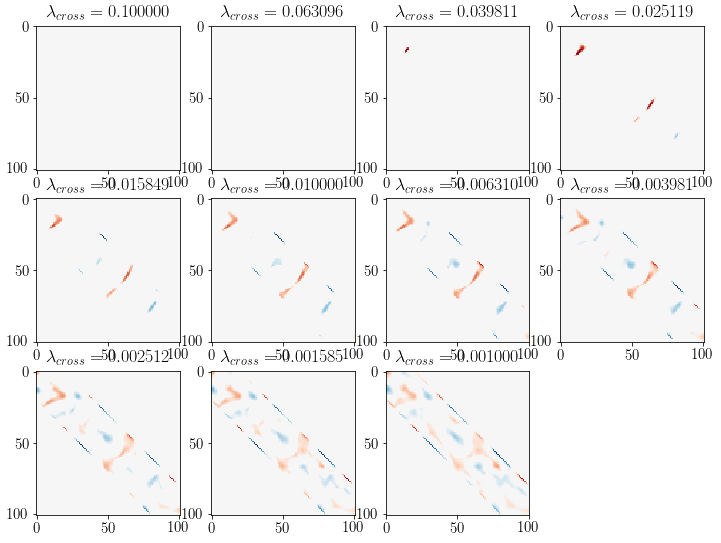

In [17]:
plt.figure(figsize=(12,3*np.ceil(lambdas.shape[-1]/4)))
for iter_lambda, (lambda_cross, lambda_auto, lambda_diag, lambda_ridge) \
in enumerate(zip(*lambdas)):
    plt.subplot(np.ceil(lambdas.shape[-1]/4), 4, iter_lambda+1)
    ldn.imshow(Omegas_cv[0, iter_lambda,:num_time,num_time:], identity=True)
    plt.title(r'$\lambda_{cross} = %f$'%lambda_cross)

In [18]:
fds_cv = np.sum(Omegas_cv[:,:,:num_time,num_time:]!=0,(0,-2,-1))/num_cv
fdrs_cv = np.sum(Omegas_cv[:,:,:num_time,num_time:]!=0,(0,-2,-1))/np.sum(time_graph_cross)/num_cv

Text(0, 0.5, 'mean false discovery')

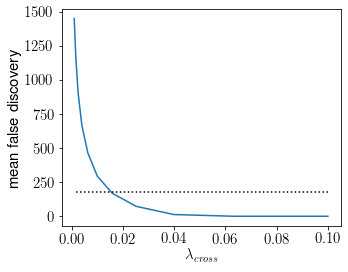

In [19]:
plt.figure(figsize=(5,4))
plt.plot(lambdas[0], fds_cv)
plt.plot(lambdas[0], np.full(lambdas[0].shape, 0.05*np.sum(time_graph_cross)), color='black', linestyle=':')
plt.xlabel(r"$\lambda_{cross}$")
plt.ylabel(r"mean false discovery")

# cv result

In [20]:
id_cv = np.argmax(fdrs_cv[fdrs_cv < 0.05])

In [21]:
lambda_cross, lambda_auto, lambda_diag, lambda_ridge = lambdas.T[id_cv]
lambda_cross, lambda_auto, lambda_diag, lambda_ridge

(0.01584893192461114, 0.0, 0.5, 0.0)

In [22]:
lambda_graph = np.array(np.block(
    [[(1+lambda_auto)*(time_graph_auto-np.eye(num_time)) + (1+lambda_diag)*np.eye(num_time), (1+lambda_cross)*time_graph_cross],
     [(1+lambda_cross)*time_graph_cross, (1+lambda_auto)*(time_graph_auto-np.eye(num_time)) + (1+lambda_diag)*np.eye(num_time)]])) -1

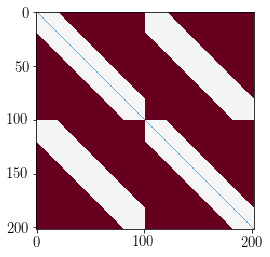

In [24]:
ldn.imshow(lambda_graph)

In [26]:
Omega_est, Sigma_est, latent_est, weight_est =\
    ldn.fit(data, lambda_diag, lambda_cross, offset_cross,
            lambda_auto, offset_auto, 
            ths_glasso=1e-6, ths_lasso=1e-6, verbose=True)

1-th iter, nll: 110.251651, change: 0.128577, lapse: 9.310028
2-th iter, nll: 110.177813, change: 0.006249, lapse: 7.339556
3-th iter, nll: 110.116564, change: 0.004462, lapse: 6.452168
4-th iter, nll: 110.063647, change: 0.003490, lapse: 6.738722
5-th iter, nll: 110.016958, change: 0.003204, lapse: 6.440609
6-th iter, nll: 109.975229, change: 0.003000, lapse: 6.030975
7-th iter, nll: 109.937589, change: 0.002856, lapse: 6.162596
8-th iter, nll: 109.903402, change: 0.002738, lapse: 6.336009
9-th iter, nll: 109.872178, change: 0.002636, lapse: 5.738218
10-th iter, nll: 109.843534, change: 0.002540, lapse: 5.397009
11-th iter, nll: 109.817159, change: 0.002446, lapse: 5.137321
12-th iter, nll: 109.792797, change: 0.002353, lapse: 4.995565
13-th iter, nll: 109.770235, change: 0.002262, lapse: 5.418304
14-th iter, nll: 109.749291, change: 0.002178, lapse: 4.816918
15-th iter, nll: 109.729808, change: 0.002098, lapse: 4.846606
16-th iter, nll: 109.711652, change: 0.002020, lapse: 5.138434
1

In [27]:
dspr_est = 2*Omega_est - Omega_est @ Sigma_est @ Omega_est

## plots

Text(0, 0.5, 'V4 at time $s$ sec.')

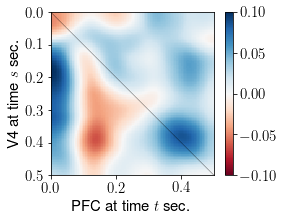

In [29]:
plt.figure(figsize=(4,3))
ldn.imshow(Sigma_est[:num_time,num_time:], time=rec_time, identity=True); plt.colorbar()
plt.xlabel(r"PFC at time $t$ sec."); plt.ylabel(r"V4 at time $s$ sec.")

Text(0, 0.5, 'V4 at time $s$ sec.')

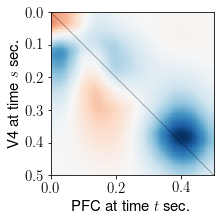

In [30]:
plt.figure(figsize=(3,3))
ldn.imshow(np.linalg.inv(Omega_est)[:num_time,num_time:], time=rec_time, identity=True)
plt.xlabel(r"PFC at time $t$ sec."); plt.ylabel(r"V4 at time $s$ sec.")

Text(0, 0.5, 'V4 at time $s$ sec.')

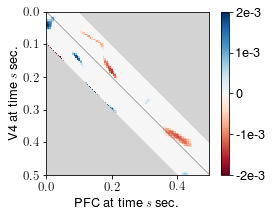

In [538]:
fig, ax = plt.subplots(figsize=(4,3))
ldn.imshow(Omega_est[:num_time,num_time:], time=rec_time, identity=True)

ax.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
ax.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')
plt.clim(-0.002,0.002); cbar = plt.colorbar(ticks=[-0.002, -0.001, 0.0, 0.001, 0.002])
cbar.ax.set_yticklabels(['-2e-3','-1e-3','0','1e-3','2e-3'])
ax.set_xlim(rec_time[0], rec_time[1]); ax.set_ylim(rec_time[1], rec_time[0])
ax.set_xlabel(r"PFC at time $s$ sec."); ax.set_ylabel(r"V4 at time $s$ sec.")

# 2. Permutation test

In [35]:
num_perm = 2000

In [36]:
init_arg = {'Omega_init': Omegas_cv[0,id_cv],
            'weight_init': weights_cv[id_cv]}

In [37]:
Omegas_perm = np.zeros([num_perm, 2*num_time, 2*num_time])
Sigmas_perm = np.zeros([num_perm, 2*num_time, 2*num_time])

for iter_perm in range(num_perm):    
    while True:
        with np.errstate(all='raise'):
            try:
                start_perm = time.time()
                
                # random sample
                trial_sample = np.random.choice(num_trial, num_trial, False)
                data_bst = [data[0], data[1][:,:,trial_sample]]

                # permutation
                Omega_perm, Sigma_perm, latent_perm, weight_perm \
                = ldn.fit(data_bst, lambda_diag, lambda_cross, offset_cross,
                          lambda_auto, offset_auto, 
                          ths_glasso=1e-6, ths_lasso=1e-6, verbose=True,
                          **init_arg)
        
                
            except FloatingPointError:
                sys.__stdout__.write("%d-th permutation encountered FloatingPointError, lapse:%.3fsec.\n"
                                     %(iter_perm+1, time.time()-start_perm))
                sys.__stdout__.write("Retrying...\n")
                sys.__stdout__.flush()
                continue
                
            init_arg = {'Omega_init':Omega_perm, 'weight_init':weight_perm}
                        
            # save result
            Omegas_perm[iter_perm] = Omega_perm
            Sigmas_perm[iter_perm] = Sigma_perm
            
            sys.__stdout__.write("%d-th permutation finished, lapse: %.3fsec.\n"
                          %(iter_perm+1, time.time()-start_perm))
            sys.__stdout__.flush()
            break

1-th iter, nll: 109.477434, change: 0.043166, lapse: 4.152826
2-th iter, nll: 109.474103, change: 0.000747, lapse: 4.010563
1-th iter, nll: 109.473673, change: 0.046603, lapse: 4.025383
2-th iter, nll: 109.470654, change: 0.000693, lapse: 3.872272
1-th iter, nll: 109.466669, change: 0.026012, lapse: 3.831795
2-th iter, nll: 109.463932, change: 0.000677, lapse: 3.715976
1-th iter, nll: 109.460481, change: 0.047834, lapse: 4.322359
2-th iter, nll: 109.457984, change: 0.000623, lapse: 3.811552
1-th iter, nll: 109.456431, change: 0.036702, lapse: 3.661099
2-th iter, nll: 109.454165, change: 0.000594, lapse: 3.775234
1-th iter, nll: 109.451899, change: 0.044000, lapse: 3.645266
2-th iter, nll: 109.449829, change: 0.000565, lapse: 3.617498
1-th iter, nll: 109.448720, change: 0.024434, lapse: 3.507503
2-th iter, nll: 109.446839, change: 0.000536, lapse: 3.612768
1-th iter, nll: 109.445136, change: 0.028586, lapse: 3.510723
2-th iter, nll: 109.443430, change: 0.000508, lapse: 3.507632
1-th ite

2-th iter, nll: 109.401844, change: 0.000114, lapse: 1.879485
1-th iter, nll: 109.401895, change: 0.043195, lapse: 3.021116
2-th iter, nll: 109.401868, change: 0.000072, lapse: 1.883273
1-th iter, nll: 109.401886, change: 0.031375, lapse: 2.563126
2-th iter, nll: 109.401860, change: 0.000050, lapse: 1.778549
1-th iter, nll: 109.401894, change: 0.044767, lapse: 2.258940
2-th iter, nll: 109.401870, change: 0.000062, lapse: 1.656548
1-th iter, nll: 109.401796, change: 0.026756, lapse: 2.569622
2-th iter, nll: 109.401774, change: 0.000070, lapse: 1.875303
1-th iter, nll: 109.401380, change: 0.046374, lapse: 3.158292
2-th iter, nll: 109.401357, change: 0.000078, lapse: 1.864997
1-th iter, nll: 109.399681, change: 0.044721, lapse: 3.381456
2-th iter, nll: 109.399656, change: 0.000105, lapse: 1.775838
1-th iter, nll: 109.402432, change: 0.069234, lapse: 3.124771
2-th iter, nll: 109.402412, change: 0.000065, lapse: 1.688214
1-th iter, nll: 109.400993, change: 0.035582, lapse: 2.525666
2-th ite

1-th iter, nll: 109.401272, change: 0.044526, lapse: 2.610127
2-th iter, nll: 109.401269, change: 0.000060, lapse: 1.261268
1-th iter, nll: 109.401794, change: 0.039389, lapse: 2.505373
2-th iter, nll: 109.401791, change: 0.000041, lapse: 1.431927
1-th iter, nll: 109.401975, change: 0.023751, lapse: 1.962756
2-th iter, nll: 109.401973, change: 0.000062, lapse: 1.410632
1-th iter, nll: 109.401456, change: 0.035156, lapse: 2.095677
2-th iter, nll: 109.401453, change: 0.000048, lapse: 1.430856
1-th iter, nll: 109.402411, change: 0.028079, lapse: 1.981251
2-th iter, nll: 109.402409, change: 0.000041, lapse: 1.206668
1-th iter, nll: 109.401645, change: 0.031619, lapse: 2.310181
2-th iter, nll: 109.401643, change: 0.000040, lapse: 1.417268
1-th iter, nll: 109.400044, change: 0.044952, lapse: 2.751238
2-th iter, nll: 109.400040, change: 0.000056, lapse: 1.461382
1-th iter, nll: 109.400080, change: 0.033692, lapse: 2.641530
2-th iter, nll: 109.400075, change: 0.000068, lapse: 1.676341
1-th ite

2-th iter, nll: 109.401470, change: 0.000052, lapse: 1.329505
1-th iter, nll: 109.400925, change: 0.037223, lapse: 2.674712
2-th iter, nll: 109.400923, change: 0.000036, lapse: 1.468674
1-th iter, nll: 109.400466, change: 0.041162, lapse: 2.685860
2-th iter, nll: 109.400462, change: 0.000059, lapse: 1.337807
1-th iter, nll: 109.402174, change: 0.025968, lapse: 2.587114
2-th iter, nll: 109.402173, change: 0.000024, lapse: 1.337067
1-th iter, nll: 109.401325, change: 0.050422, lapse: 2.673943
2-th iter, nll: 109.401324, change: 0.000052, lapse: 1.433897
1-th iter, nll: 109.401750, change: 0.039311, lapse: 2.239702
2-th iter, nll: 109.401748, change: 0.000038, lapse: 1.450249
1-th iter, nll: 109.401644, change: 0.026186, lapse: 2.321020
2-th iter, nll: 109.401643, change: 0.000041, lapse: 1.436097
1-th iter, nll: 109.401770, change: 0.031254, lapse: 2.327969
2-th iter, nll: 109.401768, change: 0.000035, lapse: 1.438719
1-th iter, nll: 109.400704, change: 0.039734, lapse: 2.393368
2-th ite

1-th iter, nll: 109.401611, change: 0.046854, lapse: 2.445553
2-th iter, nll: 109.401609, change: 0.000043, lapse: 1.485314
1-th iter, nll: 109.402352, change: 0.025428, lapse: 2.236641
2-th iter, nll: 109.402351, change: 0.000038, lapse: 1.349013
1-th iter, nll: 109.400900, change: 0.040326, lapse: 2.229687
2-th iter, nll: 109.400897, change: 0.000084, lapse: 1.445446
1-th iter, nll: 109.400462, change: 0.044242, lapse: 2.993721
2-th iter, nll: 109.400458, change: 0.000056, lapse: 1.660502
1-th iter, nll: 109.400809, change: 0.045609, lapse: 2.514350
2-th iter, nll: 109.400805, change: 0.000062, lapse: 1.222241
1-th iter, nll: 109.401921, change: 0.045989, lapse: 2.262128
2-th iter, nll: 109.401920, change: 0.000031, lapse: 1.641488
1-th iter, nll: 109.401342, change: 0.036125, lapse: 2.339534
2-th iter, nll: 109.401340, change: 0.000053, lapse: 1.540714
1-th iter, nll: 109.401271, change: 0.033280, lapse: 2.946693
2-th iter, nll: 109.401269, change: 0.000064, lapse: 1.429520
1-th ite

2-th iter, nll: 109.402368, change: 0.000026, lapse: 1.336318
1-th iter, nll: 109.400733, change: 0.036582, lapse: 2.765624
2-th iter, nll: 109.400729, change: 0.000095, lapse: 1.322135
1-th iter, nll: 109.402352, change: 0.034205, lapse: 2.421335
2-th iter, nll: 109.402350, change: 0.000037, lapse: 1.439748
1-th iter, nll: 109.400635, change: 0.038432, lapse: 2.527931
2-th iter, nll: 109.400632, change: 0.000064, lapse: 1.529813
1-th iter, nll: 109.401491, change: 0.035045, lapse: 2.671678
2-th iter, nll: 109.401489, change: 0.000053, lapse: 1.342544
1-th iter, nll: 109.399772, change: 0.047256, lapse: 2.646545
2-th iter, nll: 109.399766, change: 0.000115, lapse: 1.846272
1-th iter, nll: 109.401302, change: 0.048141, lapse: 2.530998
2-th iter, nll: 109.401300, change: 0.000053, lapse: 1.529798
1-th iter, nll: 109.399273, change: 0.041599, lapse: 2.696953
2-th iter, nll: 109.399269, change: 0.000057, lapse: 1.328497
1-th iter, nll: 109.400135, change: 0.076827, lapse: 3.818601
2-th ite

1-th iter, nll: 109.401326, change: 0.021468, lapse: 2.659063
2-th iter, nll: 109.401324, change: 0.000049, lapse: 1.223075
1-th iter, nll: 109.402081, change: 0.022366, lapse: 2.250290
2-th iter, nll: 109.402080, change: 0.000030, lapse: 1.296613
1-th iter, nll: 109.400828, change: 0.033342, lapse: 2.217033
2-th iter, nll: 109.400824, change: 0.000057, lapse: 1.429436
1-th iter, nll: 109.400819, change: 0.053687, lapse: 2.754818
2-th iter, nll: 109.400816, change: 0.000056, lapse: 1.463655
1-th iter, nll: 109.402020, change: 0.032271, lapse: 2.108561
2-th iter, nll: 109.402018, change: 0.000042, lapse: 1.324779
1-th iter, nll: 109.398230, change: 0.053116, lapse: 2.448624
2-th iter, nll: 109.398224, change: 0.000055, lapse: 1.548853
1-th iter, nll: 109.401444, change: 0.057169, lapse: 2.972672
2-th iter, nll: 109.401442, change: 0.000030, lapse: 1.652973
1-th iter, nll: 109.401393, change: 0.037161, lapse: 3.103519
2-th iter, nll: 109.401390, change: 0.000059, lapse: 1.328725
1-th ite

2-th iter, nll: 109.401447, change: 0.000034, lapse: 1.324605
1-th iter, nll: 109.401747, change: 0.032234, lapse: 2.215133
2-th iter, nll: 109.401746, change: 0.000048, lapse: 1.332048
1-th iter, nll: 109.401508, change: 0.031336, lapse: 2.431349
2-th iter, nll: 109.401506, change: 0.000086, lapse: 1.440954
1-th iter, nll: 109.401387, change: 0.049382, lapse: 2.126872
2-th iter, nll: 109.401385, change: 0.000041, lapse: 1.662814
1-th iter, nll: 109.400898, change: 0.030963, lapse: 2.559869
2-th iter, nll: 109.400895, change: 0.000065, lapse: 1.223346
1-th iter, nll: 109.401777, change: 0.032573, lapse: 2.329042
2-th iter, nll: 109.401775, change: 0.000056, lapse: 1.438288
1-th iter, nll: 109.400826, change: 0.045976, lapse: 2.523969
2-th iter, nll: 109.400823, change: 0.000056, lapse: 1.325678
1-th iter, nll: 109.401340, change: 0.036546, lapse: 2.148469
2-th iter, nll: 109.401337, change: 0.000073, lapse: 1.335318
1-th iter, nll: 109.400544, change: 0.032251, lapse: 2.338696
2-th ite

1-th iter, nll: 109.401741, change: 0.029599, lapse: 2.345424
2-th iter, nll: 109.401739, change: 0.000044, lapse: 1.461022
1-th iter, nll: 109.402534, change: 0.022822, lapse: 1.991341
2-th iter, nll: 109.402533, change: 0.000041, lapse: 1.315129
1-th iter, nll: 109.402030, change: 0.018830, lapse: 2.084663
2-th iter, nll: 109.402028, change: 0.000036, lapse: 1.384966
1-th iter, nll: 109.401314, change: 0.029295, lapse: 2.397931
2-th iter, nll: 109.401311, change: 0.000093, lapse: 1.423493
1-th iter, nll: 109.401304, change: 0.035867, lapse: 2.366819
2-th iter, nll: 109.401302, change: 0.000057, lapse: 1.526520
1-th iter, nll: 109.401905, change: 0.038843, lapse: 2.278372
2-th iter, nll: 109.401903, change: 0.000048, lapse: 1.467330
1-th iter, nll: 109.401479, change: 0.028332, lapse: 2.404916
2-th iter, nll: 109.401477, change: 0.000056, lapse: 1.558731
1-th iter, nll: 109.401977, change: 0.026611, lapse: 1.857460
2-th iter, nll: 109.401975, change: 0.000040, lapse: 1.418220
1-th ite

2-th iter, nll: 109.401303, change: 0.000051, lapse: 1.496459
1-th iter, nll: 109.400600, change: 0.037652, lapse: 2.854600
2-th iter, nll: 109.400595, change: 0.000084, lapse: 1.530833
1-th iter, nll: 109.402069, change: 0.046732, lapse: 2.539426
2-th iter, nll: 109.402067, change: 0.000084, lapse: 1.438243
1-th iter, nll: 109.401648, change: 0.027131, lapse: 2.630149
2-th iter, nll: 109.401645, change: 0.000047, lapse: 1.309683
1-th iter, nll: 109.400367, change: 0.049443, lapse: 2.734510
2-th iter, nll: 109.400363, change: 0.000093, lapse: 1.959884
1-th iter, nll: 109.401820, change: 0.042885, lapse: 2.408445
2-th iter, nll: 109.401819, change: 0.000028, lapse: 1.623247
1-th iter, nll: 109.401669, change: 0.024603, lapse: 2.116713
2-th iter, nll: 109.401667, change: 0.000036, lapse: 1.441689
1-th iter, nll: 109.401507, change: 0.041390, lapse: 2.512600
2-th iter, nll: 109.401505, change: 0.000040, lapse: 1.308470
1-th iter, nll: 109.399341, change: 0.038117, lapse: 2.793505
2-th ite

1-th iter, nll: 109.400634, change: 0.039887, lapse: 2.880892
2-th iter, nll: 109.400631, change: 0.000061, lapse: 1.758213
1-th iter, nll: 109.400639, change: 0.044252, lapse: 2.343563
2-th iter, nll: 109.400636, change: 0.000036, lapse: 1.544682
1-th iter, nll: 109.401463, change: 0.040907, lapse: 2.648849
2-th iter, nll: 109.401462, change: 0.000048, lapse: 1.759199
1-th iter, nll: 109.401329, change: 0.030121, lapse: 2.010537
2-th iter, nll: 109.401326, change: 0.000094, lapse: 1.441059
1-th iter, nll: 109.400881, change: 0.040204, lapse: 2.756653
2-th iter, nll: 109.400878, change: 0.000059, lapse: 1.348111
1-th iter, nll: 109.396048, change: 0.074117, lapse: 3.063941
2-th iter, nll: 109.396043, change: 0.000060, lapse: 1.440504
1-th iter, nll: 109.401769, change: 0.075470, lapse: 2.539469
2-th iter, nll: 109.401766, change: 0.000046, lapse: 1.639980
1-th iter, nll: 109.400226, change: 0.048659, lapse: 2.677908
2-th iter, nll: 109.400222, change: 0.000063, lapse: 1.544847
1-th ite

2-th iter, nll: 109.401127, change: 0.000059, lapse: 1.438021
1-th iter, nll: 109.399266, change: 0.041687, lapse: 3.304680
2-th iter, nll: 109.399260, change: 0.000137, lapse: 1.555786
1-th iter, nll: 109.401240, change: 0.042528, lapse: 2.667518
2-th iter, nll: 109.401236, change: 0.000072, lapse: 1.541478
1-th iter, nll: 109.401418, change: 0.032499, lapse: 2.474764
2-th iter, nll: 109.401415, change: 0.000060, lapse: 1.651128
1-th iter, nll: 109.401850, change: 0.026774, lapse: 1.671693
2-th iter, nll: 109.401849, change: 0.000046, lapse: 1.140974
1-th iter, nll: 109.401555, change: 0.028701, lapse: 2.031268
2-th iter, nll: 109.401553, change: 0.000055, lapse: 1.353159
1-th iter, nll: 109.401758, change: 0.030138, lapse: 2.511249
2-th iter, nll: 109.401756, change: 0.000055, lapse: 1.306157
1-th iter, nll: 109.401380, change: 0.026726, lapse: 2.817661
2-th iter, nll: 109.401379, change: 0.000041, lapse: 1.630410
1-th iter, nll: 109.401462, change: 0.035038, lapse: 2.165008
2-th ite

1-th iter, nll: 109.402119, change: 0.040867, lapse: 2.125885
2-th iter, nll: 109.402117, change: 0.000038, lapse: 1.244200
1-th iter, nll: 109.401518, change: 0.030683, lapse: 2.208696
2-th iter, nll: 109.401516, change: 0.000049, lapse: 1.224481
1-th iter, nll: 109.402387, change: 0.036765, lapse: 2.103505
2-th iter, nll: 109.402387, change: 0.000027, lapse: 1.224809
1-th iter, nll: 109.402002, change: 0.016319, lapse: 1.766730
2-th iter, nll: 109.402001, change: 0.000047, lapse: 1.111580
1-th iter, nll: 109.401973, change: 0.027226, lapse: 2.139335
2-th iter, nll: 109.401972, change: 0.000059, lapse: 1.384530
1-th iter, nll: 109.401486, change: 0.032908, lapse: 2.210375
2-th iter, nll: 109.401484, change: 0.000048, lapse: 1.330676
1-th iter, nll: 109.402497, change: 0.021702, lapse: 1.953054
2-th iter, nll: 109.402496, change: 0.000025, lapse: 1.498730
1-th iter, nll: 109.401806, change: 0.033538, lapse: 2.125083
2-th iter, nll: 109.401805, change: 0.000047, lapse: 1.422189
1-th ite

2-th iter, nll: 109.402110, change: 0.000028, lapse: 1.331210
1-th iter, nll: 109.402244, change: 0.020723, lapse: 2.437659
2-th iter, nll: 109.402244, change: 0.000033, lapse: 1.423353
1-th iter, nll: 109.397863, change: 0.056808, lapse: 3.105766
2-th iter, nll: 109.397856, change: 0.000089, lapse: 1.773091
1-th iter, nll: 109.401556, change: 0.064714, lapse: 2.525429
2-th iter, nll: 109.401553, change: 0.000054, lapse: 1.307539
1-th iter, nll: 109.400701, change: 0.043748, lapse: 2.125692
2-th iter, nll: 109.400697, change: 0.000065, lapse: 1.728213
1-th iter, nll: 109.402396, change: 0.040021, lapse: 2.066693
2-th iter, nll: 109.402395, change: 0.000039, lapse: 1.302806
1-th iter, nll: 109.401839, change: 0.027004, lapse: 2.409833
2-th iter, nll: 109.401837, change: 0.000045, lapse: 1.237118
1-th iter, nll: 109.400514, change: 0.053241, lapse: 3.033807
2-th iter, nll: 109.400509, change: 0.000125, lapse: 1.318597
1-th iter, nll: 109.401438, change: 0.047440, lapse: 2.583938
2-th ite

1-th iter, nll: 109.401741, change: 0.021197, lapse: 2.206943
2-th iter, nll: 109.401739, change: 0.000064, lapse: 1.329745
1-th iter, nll: 109.402213, change: 0.036143, lapse: 2.228701
2-th iter, nll: 109.402212, change: 0.000051, lapse: 1.455995
1-th iter, nll: 109.400721, change: 0.036922, lapse: 2.754019
2-th iter, nll: 109.400718, change: 0.000064, lapse: 1.223947
1-th iter, nll: 109.399399, change: 0.042628, lapse: 3.127589
2-th iter, nll: 109.399393, change: 0.000089, lapse: 1.661589
1-th iter, nll: 109.401647, change: 0.039416, lapse: 2.977227
2-th iter, nll: 109.401644, change: 0.000046, lapse: 1.859894
1-th iter, nll: 109.401512, change: 0.035674, lapse: 2.564106
2-th iter, nll: 109.401510, change: 0.000054, lapse: 1.236389
1-th iter, nll: 109.401248, change: 0.028106, lapse: 2.330167
2-th iter, nll: 109.401245, change: 0.000049, lapse: 1.428902
1-th iter, nll: 109.401557, change: 0.039556, lapse: 2.735334
2-th iter, nll: 109.401555, change: 0.000045, lapse: 1.647074
1-th ite

2-th iter, nll: 109.400038, change: 0.000066, lapse: 1.332290
1-th iter, nll: 109.400787, change: 0.051654, lapse: 3.337222
2-th iter, nll: 109.400784, change: 0.000053, lapse: 1.562657
1-th iter, nll: 109.401091, change: 0.047669, lapse: 3.262550
2-th iter, nll: 109.401088, change: 0.000049, lapse: 1.599771
1-th iter, nll: 109.401567, change: 0.043504, lapse: 2.107837
2-th iter, nll: 109.401565, change: 0.000068, lapse: 1.431648
1-th iter, nll: 109.400888, change: 0.047118, lapse: 2.429881
2-th iter, nll: 109.400885, change: 0.000052, lapse: 1.784761
1-th iter, nll: 109.400122, change: 0.040775, lapse: 2.307939
2-th iter, nll: 109.400118, change: 0.000056, lapse: 1.436277
1-th iter, nll: 109.401424, change: 0.046465, lapse: 1.985696
2-th iter, nll: 109.401422, change: 0.000055, lapse: 1.427493
1-th iter, nll: 109.401740, change: 0.038961, lapse: 2.438143
2-th iter, nll: 109.401738, change: 0.000045, lapse: 1.655921
1-th iter, nll: 109.401651, change: 0.031273, lapse: 2.302752
2-th ite

1-th iter, nll: 109.401418, change: 0.033413, lapse: 2.630938
2-th iter, nll: 109.401415, change: 0.000064, lapse: 1.838310
1-th iter, nll: 109.402437, change: 0.023674, lapse: 2.066447
2-th iter, nll: 109.402436, change: 0.000032, lapse: 1.733818
1-th iter, nll: 109.401143, change: 0.031309, lapse: 2.654339
2-th iter, nll: 109.401141, change: 0.000049, lapse: 1.446405
1-th iter, nll: 109.401687, change: 0.031570, lapse: 2.887213
2-th iter, nll: 109.401685, change: 0.000077, lapse: 1.224300
1-th iter, nll: 109.401279, change: 0.027066, lapse: 2.445069
2-th iter, nll: 109.401277, change: 0.000049, lapse: 1.447853
1-th iter, nll: 109.398366, change: 0.038598, lapse: 3.009039
2-th iter, nll: 109.398358, change: 0.000147, lapse: 1.546736
1-th iter, nll: 109.401929, change: 0.051037, lapse: 2.300248
2-th iter, nll: 109.401927, change: 0.000030, lapse: 1.757717
1-th iter, nll: 109.401026, change: 0.030094, lapse: 2.327763
2-th iter, nll: 109.401024, change: 0.000052, lapse: 1.550163
1-th ite

2-th iter, nll: 109.401000, change: 0.000037, lapse: 1.442848
1-th iter, nll: 109.401292, change: 0.030053, lapse: 2.322309
2-th iter, nll: 109.401289, change: 0.000046, lapse: 1.440943
1-th iter, nll: 109.401566, change: 0.041691, lapse: 2.689007
2-th iter, nll: 109.401564, change: 0.000042, lapse: 1.601828
1-th iter, nll: 109.401072, change: 0.038461, lapse: 2.536315
2-th iter, nll: 109.401069, change: 0.000050, lapse: 1.430927
1-th iter, nll: 109.401279, change: 0.037226, lapse: 2.566350
2-th iter, nll: 109.401277, change: 0.000076, lapse: 1.237106
1-th iter, nll: 109.402106, change: 0.027771, lapse: 2.257834
2-th iter, nll: 109.402105, change: 0.000029, lapse: 1.544959
1-th iter, nll: 109.400348, change: 0.033941, lapse: 2.356746
2-th iter, nll: 109.400345, change: 0.000054, lapse: 1.872705
1-th iter, nll: 109.401857, change: 0.041494, lapse: 2.651865
2-th iter, nll: 109.401855, change: 0.000045, lapse: 1.440284
1-th iter, nll: 109.401457, change: 0.032086, lapse: 2.453784
2-th ite

1-th iter, nll: 109.400793, change: 0.034276, lapse: 2.235712
2-th iter, nll: 109.400789, change: 0.000053, lapse: 1.325755
1-th iter, nll: 109.401212, change: 0.043214, lapse: 2.845040
2-th iter, nll: 109.401209, change: 0.000074, lapse: 1.532959
1-th iter, nll: 109.400772, change: 0.042212, lapse: 2.594552
2-th iter, nll: 109.400768, change: 0.000077, lapse: 1.526950
1-th iter, nll: 109.399392, change: 0.059932, lapse: 2.274432
2-th iter, nll: 109.399387, change: 0.000063, lapse: 1.340567
1-th iter, nll: 109.401723, change: 0.049017, lapse: 2.530651
2-th iter, nll: 109.401721, change: 0.000041, lapse: 1.438357
1-th iter, nll: 109.402411, change: 0.016522, lapse: 2.194570
2-th iter, nll: 109.402410, change: 0.000023, lapse: 1.634800
1-th iter, nll: 109.401188, change: 0.040858, lapse: 2.478670
2-th iter, nll: 109.401186, change: 0.000048, lapse: 1.452448
1-th iter, nll: 109.397492, change: 0.066211, lapse: 2.481171
2-th iter, nll: 109.397484, change: 0.000109, lapse: 1.520034
1-th ite

2-th iter, nll: 109.401787, change: 0.000048, lapse: 1.216048
1-th iter, nll: 109.400916, change: 0.037661, lapse: 3.184267
2-th iter, nll: 109.400912, change: 0.000121, lapse: 1.338933
1-th iter, nll: 109.400553, change: 0.035359, lapse: 3.039182
2-th iter, nll: 109.400549, change: 0.000053, lapse: 1.813832
1-th iter, nll: 109.401156, change: 0.055969, lapse: 2.891304
2-th iter, nll: 109.401154, change: 0.000054, lapse: 1.448418
1-th iter, nll: 109.399819, change: 0.052861, lapse: 3.541940
2-th iter, nll: 109.399815, change: 0.000061, lapse: 1.438980
1-th iter, nll: 109.402230, change: 0.048292, lapse: 2.342344
2-th iter, nll: 109.402229, change: 0.000038, lapse: 1.540662
1-th iter, nll: 109.399746, change: 0.049994, lapse: 2.534016
2-th iter, nll: 109.399739, change: 0.000109, lapse: 1.336758
1-th iter, nll: 109.401597, change: 0.044010, lapse: 1.875682
2-th iter, nll: 109.401596, change: 0.000043, lapse: 1.429117
1-th iter, nll: 109.402203, change: 0.027556, lapse: 2.502346
2-th ite

1-th iter, nll: 109.401410, change: 0.036839, lapse: 2.303222
2-th iter, nll: 109.401408, change: 0.000061, lapse: 1.310320
1-th iter, nll: 109.402422, change: 0.030589, lapse: 2.003921
2-th iter, nll: 109.402421, change: 0.000033, lapse: 1.200316
1-th iter, nll: 109.401245, change: 0.030354, lapse: 1.862750
2-th iter, nll: 109.401242, change: 0.000063, lapse: 1.198164
1-th iter, nll: 109.401265, change: 0.036539, lapse: 2.493062
2-th iter, nll: 109.401262, change: 0.000049, lapse: 1.193867
1-th iter, nll: 109.401313, change: 0.036985, lapse: 2.386207
2-th iter, nll: 109.401311, change: 0.000062, lapse: 1.193642
1-th iter, nll: 109.400540, change: 0.044797, lapse: 3.126314
2-th iter, nll: 109.400538, change: 0.000052, lapse: 1.394662
1-th iter, nll: 109.401834, change: 0.040530, lapse: 2.323624
2-th iter, nll: 109.401832, change: 0.000045, lapse: 1.509137
1-th iter, nll: 109.401701, change: 0.034181, lapse: 2.084773
2-th iter, nll: 109.401699, change: 0.000065, lapse: 1.191488
1-th ite

2-th iter, nll: 109.400447, change: 0.000063, lapse: 1.336132
1-th iter, nll: 109.401232, change: 0.028361, lapse: 2.766191
2-th iter, nll: 109.401229, change: 0.000072, lapse: 1.559254
1-th iter, nll: 109.400777, change: 0.027876, lapse: 2.430462
2-th iter, nll: 109.400775, change: 0.000041, lapse: 1.435070
1-th iter, nll: 109.400614, change: 0.051971, lapse: 2.901208
2-th iter, nll: 109.400611, change: 0.000051, lapse: 1.646036
1-th iter, nll: 109.400505, change: 0.039335, lapse: 2.934662
2-th iter, nll: 109.400502, change: 0.000044, lapse: 1.664226
1-th iter, nll: 109.400292, change: 0.041529, lapse: 2.542286
2-th iter, nll: 109.400287, change: 0.000062, lapse: 1.642052
1-th iter, nll: 109.400502, change: 0.028120, lapse: 2.760480
2-th iter, nll: 109.400498, change: 0.000066, lapse: 1.767130
1-th iter, nll: 109.402141, change: 0.045796, lapse: 2.330270
2-th iter, nll: 109.402140, change: 0.000025, lapse: 1.469561
1-th iter, nll: 109.402591, change: 0.017189, lapse: 1.983625
2-th ite

1-th iter, nll: 109.399690, change: 0.042723, lapse: 3.311925
2-th iter, nll: 109.399686, change: 0.000081, lapse: 1.806624
1-th iter, nll: 109.398907, change: 0.060566, lapse: 3.477029
2-th iter, nll: 109.398903, change: 0.000056, lapse: 1.656504
1-th iter, nll: 109.401368, change: 0.050681, lapse: 2.930401
2-th iter, nll: 109.401365, change: 0.000064, lapse: 1.431551
1-th iter, nll: 109.400635, change: 0.045383, lapse: 3.159719
2-th iter, nll: 109.400632, change: 0.000079, lapse: 1.441711
1-th iter, nll: 109.401641, change: 0.069997, lapse: 2.894678
2-th iter, nll: 109.401638, change: 0.000084, lapse: 1.649983
1-th iter, nll: 109.400763, change: 0.035907, lapse: 2.644028
2-th iter, nll: 109.400760, change: 0.000072, lapse: 1.554802
1-th iter, nll: 109.401253, change: 0.041704, lapse: 2.323467
2-th iter, nll: 109.401250, change: 0.000062, lapse: 1.434078
1-th iter, nll: 109.402307, change: 0.024302, lapse: 2.250069
2-th iter, nll: 109.402306, change: 0.000033, lapse: 1.220207
1-th ite

2-th iter, nll: 109.401968, change: 0.000063, lapse: 1.423487
1-th iter, nll: 109.401178, change: 0.036788, lapse: 2.530841
2-th iter, nll: 109.401176, change: 0.000046, lapse: 1.484722
1-th iter, nll: 109.400638, change: 0.021204, lapse: 2.788957
2-th iter, nll: 109.400634, change: 0.000049, lapse: 1.322169
1-th iter, nll: 109.401695, change: 0.033218, lapse: 2.568539
2-th iter, nll: 109.401693, change: 0.000067, lapse: 1.595018
1-th iter, nll: 109.401799, change: 0.027280, lapse: 2.680493
2-th iter, nll: 109.401797, change: 0.000042, lapse: 1.649243
1-th iter, nll: 109.400736, change: 0.038584, lapse: 2.583418
2-th iter, nll: 109.400733, change: 0.000045, lapse: 1.655540
1-th iter, nll: 109.402208, change: 0.033473, lapse: 2.563517
2-th iter, nll: 109.402207, change: 0.000048, lapse: 1.444128
1-th iter, nll: 109.401600, change: 0.026284, lapse: 2.316520
2-th iter, nll: 109.401598, change: 0.000052, lapse: 1.649793
1-th iter, nll: 109.401946, change: 0.027220, lapse: 2.546796
2-th ite

1-th iter, nll: 109.400839, change: 0.036632, lapse: 2.786932
2-th iter, nll: 109.400836, change: 0.000066, lapse: 1.385577
1-th iter, nll: 109.402069, change: 0.037094, lapse: 2.634704
2-th iter, nll: 109.402068, change: 0.000059, lapse: 1.428250
1-th iter, nll: 109.401361, change: 0.028786, lapse: 2.201550
2-th iter, nll: 109.401358, change: 0.000053, lapse: 1.534349
1-th iter, nll: 109.399451, change: 0.051302, lapse: 2.972825
2-th iter, nll: 109.399447, change: 0.000058, lapse: 1.985994
1-th iter, nll: 109.401266, change: 0.038806, lapse: 2.447065
2-th iter, nll: 109.401263, change: 0.000082, lapse: 1.331984
1-th iter, nll: 109.401869, change: 0.026825, lapse: 1.980523
2-th iter, nll: 109.401868, change: 0.000047, lapse: 1.318241
1-th iter, nll: 109.401542, change: 0.034771, lapse: 2.515833
2-th iter, nll: 109.401540, change: 0.000057, lapse: 1.539439
1-th iter, nll: 109.401899, change: 0.026805, lapse: 2.760601
2-th iter, nll: 109.401898, change: 0.000061, lapse: 1.325221
1-th ite

2-th iter, nll: 109.402067, change: 0.000061, lapse: 1.326827
1-th iter, nll: 109.401465, change: 0.043519, lapse: 1.880099
2-th iter, nll: 109.401463, change: 0.000049, lapse: 1.433814
1-th iter, nll: 109.402497, change: 0.033964, lapse: 1.879286
2-th iter, nll: 109.402497, change: 0.000020, lapse: 1.337626
1-th iter, nll: 109.402169, change: 0.018222, lapse: 1.767634
2-th iter, nll: 109.402168, change: 0.000033, lapse: 1.466403
1-th iter, nll: 109.401246, change: 0.025061, lapse: 2.104307
2-th iter, nll: 109.401244, change: 0.000050, lapse: 1.323278
1-th iter, nll: 109.400785, change: 0.040241, lapse: 3.080053
2-th iter, nll: 109.400782, change: 0.000057, lapse: 1.646743
1-th iter, nll: 109.401618, change: 0.030125, lapse: 2.122410
2-th iter, nll: 109.401615, change: 0.000058, lapse: 1.771640
1-th iter, nll: 109.400637, change: 0.046851, lapse: 2.924050
2-th iter, nll: 109.400634, change: 0.000054, lapse: 1.922020
1-th iter, nll: 109.402076, change: 0.033908, lapse: 2.586311
2-th ite

1-th iter, nll: 109.401065, change: 0.052575, lapse: 2.773628
2-th iter, nll: 109.401062, change: 0.000048, lapse: 1.694288
1-th iter, nll: 109.401063, change: 0.039579, lapse: 2.390294
2-th iter, nll: 109.401061, change: 0.000049, lapse: 1.753829
1-th iter, nll: 109.401504, change: 0.033869, lapse: 2.543581
2-th iter, nll: 109.401501, change: 0.000053, lapse: 1.486717
1-th iter, nll: 109.401850, change: 0.027927, lapse: 2.306222
2-th iter, nll: 109.401848, change: 0.000040, lapse: 1.337200
1-th iter, nll: 109.400894, change: 0.028595, lapse: 2.631045
2-th iter, nll: 109.400892, change: 0.000049, lapse: 1.258048
1-th iter, nll: 109.402189, change: 0.030191, lapse: 2.357321
2-th iter, nll: 109.402187, change: 0.000037, lapse: 1.388404
1-th iter, nll: 109.402199, change: 0.029941, lapse: 2.392763
2-th iter, nll: 109.402197, change: 0.000030, lapse: 1.322038
1-th iter, nll: 109.402510, change: 0.019400, lapse: 1.569846
2-th iter, nll: 109.402509, change: 0.000034, lapse: 1.352660
1-th ite

2-th iter, nll: 109.399835, change: 0.000047, lapse: 1.545747
1-th iter, nll: 109.400919, change: 0.043149, lapse: 2.851976
2-th iter, nll: 109.400916, change: 0.000071, lapse: 1.339031
1-th iter, nll: 109.402365, change: 0.030054, lapse: 2.670473
2-th iter, nll: 109.402364, change: 0.000035, lapse: 1.219339
1-th iter, nll: 109.400336, change: 0.033872, lapse: 2.593429
2-th iter, nll: 109.400334, change: 0.000044, lapse: 1.438717
1-th iter, nll: 109.401719, change: 0.055779, lapse: 2.661072
2-th iter, nll: 109.401717, change: 0.000038, lapse: 1.650321
1-th iter, nll: 109.401896, change: 0.032425, lapse: 2.050382
2-th iter, nll: 109.401895, change: 0.000036, lapse: 1.446530
1-th iter, nll: 109.402237, change: 0.028226, lapse: 2.266159
2-th iter, nll: 109.402236, change: 0.000021, lapse: 1.432060
1-th iter, nll: 109.401199, change: 0.024862, lapse: 2.557879
2-th iter, nll: 109.401197, change: 0.000051, lapse: 1.440701
1-th iter, nll: 109.401404, change: 0.033390, lapse: 2.565231
2-th ite

1-th iter, nll: 109.401966, change: 0.030906, lapse: 2.388185
2-th iter, nll: 109.401964, change: 0.000032, lapse: 1.519938
1-th iter, nll: 109.402322, change: 0.024556, lapse: 2.049553
2-th iter, nll: 109.402321, change: 0.000039, lapse: 1.201123
1-th iter, nll: 109.402032, change: 0.019785, lapse: 1.858767
2-th iter, nll: 109.402030, change: 0.000049, lapse: 1.202317
1-th iter, nll: 109.401504, change: 0.024654, lapse: 2.515418
2-th iter, nll: 109.401502, change: 0.000058, lapse: 1.399923
1-th iter, nll: 109.401611, change: 0.035429, lapse: 2.396341
2-th iter, nll: 109.401609, change: 0.000057, lapse: 1.267428
1-th iter, nll: 109.401834, change: 0.036539, lapse: 2.071980
2-th iter, nll: 109.401832, change: 0.000030, lapse: 1.307925
1-th iter, nll: 109.400849, change: 0.023298, lapse: 2.728486
2-th iter, nll: 109.400847, change: 0.000052, lapse: 1.320688
1-th iter, nll: 109.400112, change: 0.060592, lapse: 3.413640
2-th iter, nll: 109.400109, change: 0.000059, lapse: 1.396256
1-th ite

2-th iter, nll: 109.400132, change: 0.000052, lapse: 1.426829
1-th iter, nll: 109.400242, change: 0.057934, lapse: 2.664825
2-th iter, nll: 109.400239, change: 0.000054, lapse: 1.738938
1-th iter, nll: 109.400113, change: 0.035158, lapse: 2.911431
2-th iter, nll: 109.400109, change: 0.000072, lapse: 1.532362
1-th iter, nll: 109.401447, change: 0.047753, lapse: 2.772650
2-th iter, nll: 109.401445, change: 0.000044, lapse: 1.540794
1-th iter, nll: 109.401498, change: 0.033467, lapse: 2.522106
2-th iter, nll: 109.401495, change: 0.000063, lapse: 1.587842
1-th iter, nll: 109.402381, change: 0.032761, lapse: 1.656435
2-th iter, nll: 109.402380, change: 0.000021, lapse: 1.440849
1-th iter, nll: 109.402117, change: 0.015778, lapse: 2.048371
2-th iter, nll: 109.402116, change: 0.000043, lapse: 1.350958
1-th iter, nll: 109.402197, change: 0.019850, lapse: 2.104938
2-th iter, nll: 109.402196, change: 0.000025, lapse: 1.237666
1-th iter, nll: 109.402407, change: 0.022300, lapse: 2.555095
2-th ite

1-th iter, nll: 109.400871, change: 0.036163, lapse: 2.479715
2-th iter, nll: 109.400867, change: 0.000056, lapse: 1.310045
1-th iter, nll: 109.400818, change: 0.054596, lapse: 2.363858
2-th iter, nll: 109.400816, change: 0.000043, lapse: 1.420749
1-th iter, nll: 109.401532, change: 0.043239, lapse: 2.284319
2-th iter, nll: 109.401530, change: 0.000054, lapse: 1.308408
1-th iter, nll: 109.401984, change: 0.035285, lapse: 1.959609
2-th iter, nll: 109.401983, change: 0.000035, lapse: 1.198090
1-th iter, nll: 109.401991, change: 0.023125, lapse: 1.856386
2-th iter, nll: 109.401990, change: 0.000033, lapse: 1.399059


# 3. Inference by STAR

In [563]:
alpha = 0.05
roi = (np.abs(np.subtract(*np.where(
       np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_cross-1)

In [395]:
dspr_est = 2*Omega_est - Omega_est @ Sigma_est @ Omega_est
dsprs_perm = 2*Omegas_perm - Omegas_perm @ Sigmas_perm @ Omegas_perm

In [402]:
dist_dspr_est = (dspr_est[:num_time,num_time:] / np.std(dsprs_perm[:,:num_time,num_time:],0))

In [463]:
pval_est = np.full(dist_dspr_est.shape, 0.5)
pval_est[roi] = np.clip(2*stats.norm.cdf(-np.abs(dist_dspr_est[roi])), 1e-10, 1-1e-10)

In [564]:
R, fdp, score, mask = \
    inf.STAR_seq_step(pval_est, prop_carve = 0.05, alphas = [alpha],
                      sigma=1, mux_init=-np.log(alpha), roi=roi)
rej_STAR = mask[0]

## plots

([<matplotlib.axis.YTick at 0x7f7020099b10>,
 <a list of 6 Text yticklabel objects>)

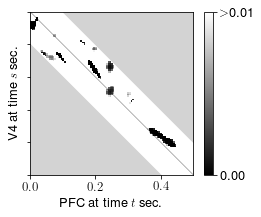

In [540]:
plt.figure(figsize=(4,3))
ldn.imshow(pval_est, cmap='gray', vmin=0, vmax=0.01, time=rec_time, identity=True)
plt.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
plt.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')

cbar = plt.colorbar(ticks=[0, 0.01])
cbar.ax.set_yticklabels(['0.00','$>$0.01'])
plt.xlabel(r"PFC at time $t$ sec."); plt.ylabel(r"V4 at time $s$ sec.")
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5], ['','','','','','',''])

([<matplotlib.axis.YTick at 0x7f701f6d5d10>,
 <a list of 6 Text yticklabel objects>)

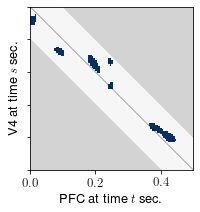

In [566]:
fig, ax = plt.subplots(figsize=(3,3))
ldn.imshow(rej_STAR, time=rec_time, identity=True)

ax.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
ax.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')
plt.clim(-0.001,0.001); # cbar = plt.colorbar(ticks=[-0.010, -0.005, 0.0, 0.005, 0.01])
# cbar.ax.set_yticklabels([r'$<$ -0.010','-0.005','0.000','0.005',r'$>$ 0.010'])
ax.set_xlim(rec_time[0], rec_time[1]), ax.set_ylim(rec_time[1], rec_time[0])
plt.xlabel(r"PFC at time $t$ sec."); plt.ylabel(r"V4 at time $s$ sec.")
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5], ['','','','','','',''])

[Text(1, 0, '-6e-3'),
 Text(1, 0, '-3e-3'),
 Text(1, 0, '0'),
 Text(1, 0, '3e-3'),
 Text(1, 0, '6e-3')]

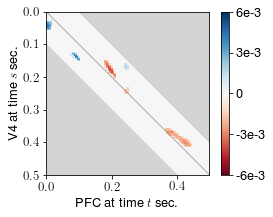

In [567]:
plt.figure(figsize=(4,3))
ldn.imshow(rej_STAR * dspr_est[:num_time,num_time:], time=rec_time, identity=True)
plt.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
plt.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')
cbar.ax.set_yticklabels([r'$<$ -2e-3','-1e-3','0','1e-3',r'$>$ 2e-3'])
plt.xlim(rec_time[0], rec_time[1]); plt.ylim(rec_time[1], rec_time[0])
plt.xlabel(r"PFC at time $t$ sec."); plt.ylabel(r"V4 at time $s$ sec.")
plt.clim(-0.006,0.006); cbar = plt.colorbar(ticks=[-0.006, -0.003, 0.0, 0.003, 0.006])
cbar.ax.set_yticklabels([r'-6e-3','-3e-3','0','3e-3',r'6e-3'])

# 4. Inference by excursion test

In [427]:
ths_nv = 0.05

In [428]:
rej_nv_est = pval_est < ths_nv
rejs_nv_perm = pvals_perm < ths_nv

In [429]:
rbs_nv_perm = np.zeros((num_perm, num_time, num_time))
nbs_nv_perm = np.zeros((num_perm,))

for iter_perm in range(num_perm):
    mask_cp = rejs_nv_perm[iter_perm].copy(); iter_blob = 0
    while np.any(mask_cp):
        iter_blob += 1
        queue = [tuple(np.transpose(np.where(mask_cp))[0])]
        mask_cp[queue[0]] = False
        while len(queue) > 0:
            cur = queue.pop(0)
            rbs_nv_perm[iter_perm, cur[0], cur[1]] = iter_blob
            if cur[0] > 0:
                if mask_cp[cur[0]-1, cur[1]]:
                    queue.append((cur[0]-1, cur[1]))
                    mask_cp[cur[0]-1, cur[1]] = False
            if cur[0] < num_time-1:
                if mask_cp[cur[0]+1, cur[1]]:
                    queue.append((cur[0]+1, cur[1]))
                    mask_cp[cur[0]+1, cur[1]] = False
            if cur[1] > 0:
                if mask_cp[cur[0], cur[1]-1]:
                    queue.append((cur[0], cur[1]-1))
                    mask_cp[cur[0], cur[1]-1] = False
            if cur[1] < num_time-1:
                if mask_cp[cur[0], cur[1]+1]:
                    queue.append((cur[0], cur[1]+1))
                    mask_cp[cur[0], cur[1]+1] = False
    nbs_nv_perm[iter_perm] = iter_blob

In [430]:
mrois_nv_perm = np.zeros(num_perm)
for iter_perm, (pval, rej_b, num_b) \
in enumerate(zip(pvals_perm, rbs_nv_perm, nbs_nv_perm)):
    rois = np.zeros(int(num_b+1))
    for iter_blob in range(1, int(num_b+1)):
        rois[iter_blob] = np.sum(-np.log(
            pvals_perm[iter_perm][rej_b == iter_blob]))
    mrois_nv_perm[iter_perm] = np.max(rois)

In [431]:
ths_roi = np.quantile(mrois_nv_perm, 0.95)

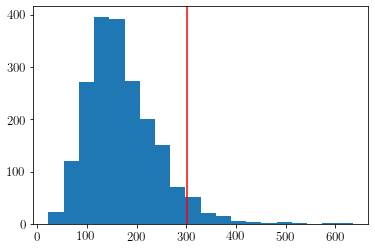

In [432]:
plt.hist(mrois_nv_perm, bins=20)
plt.axvline(x=ths_roi_nv, color='red')

In [434]:
rb_nv_est = np.zeros((num_time, num_time))

mask_cp = rej_nv_est.copy(); iter_blob = 0
while np.any(mask_cp):
    iter_blob += 1
    queue = [tuple(np.transpose(np.where(mask_cp))[0])]
    mask_cp[queue[0]] = False
    while len(queue) > 0:
        cur = queue.pop(0)
        rb_nv_est[cur[0], cur[1]] = iter_blob
        if cur[0] > 0:
            if mask_cp[cur[0]-1, cur[1]]:
                queue.append((cur[0]-1, cur[1]))
                mask_cp[cur[0]-1, cur[1]] = False
        if cur[0] < num_time-1:
            if mask_cp[cur[0]+1, cur[1]]:
                queue.append((cur[0]+1, cur[1]))
                mask_cp[cur[0]+1, cur[1]] = False
        if cur[1] > 0:
            if mask_cp[cur[0], cur[1]-1]:
                queue.append((cur[0], cur[1]-1))
                mask_cp[cur[0], cur[1]-1] = False
        if cur[1] < num_time-1:
            if mask_cp[cur[0], cur[1]+1]:
                queue.append((cur[0], cur[1]+1))
                mask_cp[cur[0], cur[1]+1] = False
nb_nv_est = iter_blob

In [435]:
rois_nv_est = np.zeros(nb_nv_est+1)
for iter_blob in range(1, nb_nv_est+1):
    rois_nv_est[iter_blob] = np.sum(-np.log(pval_est[rb_nv_est == iter_blob]))

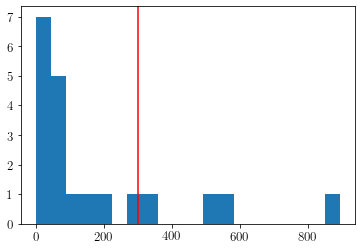

In [436]:
plt.hist(rois_nv_est, bins=20)
plt.axvline(x=ths_roi_nv, color='red')

In [439]:
np.mean(rois_nv <= mrois_nv_perm[:,None], 0)

array([1.    , 0.024 , 0.825 , 1.    , 0.997 , 0.93  , 0.0015, 0.9895,
       0.001 , 0.2105, 0.0805, 0.98  , 0.6075, 1.    , 1.    , 0.9915,
       0.    , 0.9955, 1.    , 1.    ])

## plot

Text(0.5, 0, 'series 2 at time $s$')

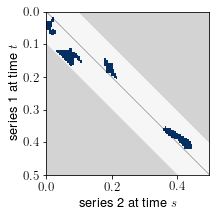

In [438]:
plt.figure(figsize=(3,3))
ldn.imshow(np.isin(rej_blobs, np.where(rois_nv > ths_roi)[0]), time=[rec_time[0], rec_time[1]], identity=True)
plt.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
plt.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')
plt.xlim(rec_time[0], rec_time[1]), plt.ylim(rec_time[1], rec_time[0])
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')

# 5. Directional lagged influence

## V4 $\rightarrow$ PFC

In [860]:
lag_target = np.arange(6,12)

In [861]:
R2_est = np.zeros(num_time-12)
for iy in np.arange(12,num_time):
    iyix = np.concatenate(([iy+num_time],iy-lag_target))
    R2_est[iy-12] = 1-1/np.linalg.inv(Sigma_est[np.ix_(iyix,iyix)])[0,0]

In [863]:
R2_perm = np.zeros([num_perm, num_time-12])
for iter_bst in np.arange(num_perm):
    for iy in np.arange(12,num_time):
        iyix = np.concatenate(([iy+num_time],iy-lag_target))
        R2_perm[iter_bst,iy-12] = \
        1-1/np.linalg.inv(Sigmas_perm[iter_bst][np.ix_(iyix,iyix)])[0,0]

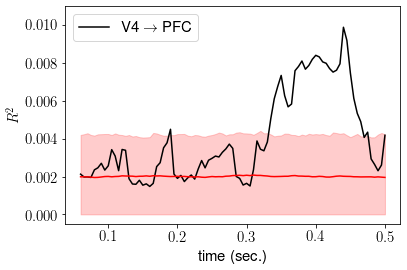

In [864]:
plt.plot(np.arange(12,num_time)*0.5/100, R2_est, color='black', label=r'V4 $\rightarrow$ PFC')
plt.plot(np.arange(12,num_time)*0.5/100, np.mean(R2_perm,0), color='red')
plt.fill_between(np.arange(12,num_time)*0.5/100, np.quantile(R2_perm,0.95,0), color='red', alpha=0.2)
# plt.axhline(y=np.quantile(R2_perm,0.95))
plt.ylim(-0.0005,0.011)
plt.xlabel('time (sec.)'); plt.ylabel(r'$R^2$'); plt.legend(loc='upper left')

## PFC $\rightarrow$ V4

In [868]:
lag_target = np.arange(6,12)

In [869]:
R2_est = np.zeros(num_time-12)
for iy in np.arange(12,num_time):
    iyix = np.concatenate(([iy],iy-lag_target+num_time))
    R2_est[iy-12] = 1-1/np.linalg.inv(Sigma_est[np.ix_(iyix,iyix)])[0,0]

In [871]:
R2_perm = np.zeros([num_perm, num_time-12])
for iter_bst in np.arange(num_perm):
    for iy in np.arange(12,num_time):
        iyix = np.concatenate(([iy],iy-lag_target+num_time))
        R2_perm[iter_bst,iy-12] = \
        1-1/np.linalg.inv(Sigmas_perm[iter_bst][np.ix_(iyix,iyix)])[0,0]

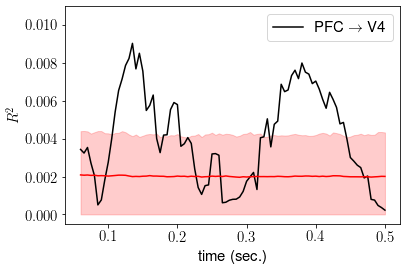

In [872]:
plt.plot(np.arange(12,num_time)*0.5/100, R2_est, color='black', label=r'PFC $\rightarrow$ V4')
plt.plot(np.arange(12,num_time)*0.5/100, np.mean(R2_perm,0), color='red')
plt.fill_between(np.arange(12,num_time)*0.5/100, np.quantile(R2_perm,0.95,0), color='red', alpha=0.2)
# plt.axhline(y=np.quantile(R2_perm,0.95))
plt.ylim(-0.0005,0.011)
plt.xlabel('time (sec.)'); plt.ylabel(r'$R^2$'); plt.legend(loc = 'upper right')

# 6. Factor loading analysis

In [789]:
covs = [[np.cov(da) for da in dat] for dat in data]

In [806]:
loadings = [
    np.matmul(covs[0],np.reshape(weight_est[:num_time], (num_time,-1,1)))[...,0],
    np.matmul(covs[1],np.reshape(weight_est[num_time:], (num_time,-1,1)))[...,0]
]

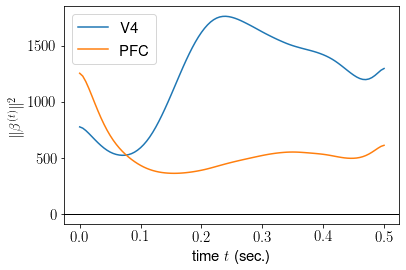

In [821]:
plt.plot(np.arange(num_time)*0.5/100,
         np.sum(np.square(loadings[0]),1), label='V4')
plt.plot(np.arange(num_time)*0.5/100,
         np.sum(np.square(loadings[1]),1), label='PFC')
plt.axhline(y=0, color='black', lw=1)
plt.xlabel('time $t$ (sec.)'); plt.ylabel(r'$\|\beta^{(t)}\|^2$'); plt.legend()
# plt.title('$\hat{\Sigma}_{12}$ between V4 leading by 40ms and PFC')

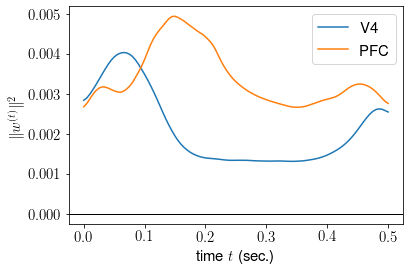

In [823]:
plt.plot(np.arange(num_time)*0.5/100,
         np.sum(np.square(weight_est[:num_time]),1), label='V4')
plt.plot(np.arange(num_time)*0.5/100,
         np.sum(np.square(weight_est[num_time:]),1), label='PFC')
plt.axhline(y=0, color='black', lw=1)
plt.xlabel('time $t$ (sec.)'); plt.ylabel(r'$\|w^{(t)}\|^2$') ; plt.legend()
# plt.title('$\hat{\Sigma}_{12}$ between V4 leading by 40ms and PFC')